# Time series forecasting with DeepAR - Wikimedia pageview data

This notebook works as a toy example: it trains a deepAR model using a small piece of wikimedia pageview data, and tests the model with synthetic data.

In [2]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

In [3]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - s3fs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.12.5  |                0         123 KB

The following packages will be UPDATED:

    ca-certificates: 2018.8.24-ha4d7672_0 conda-forge --> 2018.12.5-0      
    certifi:         2018.8.24-py36_1     conda-forge --> 2018.11.29-py36_0
    openssl:         1.0.2p-h470a237_0    conda-forge --> 1.0.2p-h14c3975_0
    s3fs:            0.1.5-py36_0                     --> 0.2.0-py36_0     


ca-certificates-2018 | 123 KB    | ##################################### | 100% 
Preparing transaction: done
Ve

In [4]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [5]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [6]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Predict setting

We predict the next 48 points of time series.
The time series that we use have hourly granularity.

In [7]:
freq = 'H'
prediction_length = 48

`context_length`: how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`.

In [8]:
context_length = 72

Useful functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3. (didn't call during this example)

In [9]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

### Get wikimedia pageview data from its restAPI
For simplicity, I aggregate all page views here. The output json file contains only one line with pageview numbers from `start` to `end`. Output files are saved in a S3 bucket.

In [12]:
import datetime
import requests
import json


def save_json(start, end, path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    ########## hardcode list here! #########
    list = ['en.wikipedia.org', 
            'de.wikipedia.org', 
            'ja.wikipedia.org', 
            'zh.wikipedia.org',
            'ru.wikipedia.org',
            'commons.wikimedia.org',
            'species.wikimedia.org',
            'en.wiktionary.org',
            'wikidata.org',
            'en.wikinews.org',
            'en.wikivoyage.org',
            'wikisource.org',
            'en.wikiversity.org',
            'en.wikibooks.org',
            'incubator.wikimedia.org',
            'wikimediafoundation.org',
            'outreach.wikimedia.org']

    # put dict of each domain to this list
    all_data = []

    delta = datetime.timedelta(days=199)

    for item in list:
        # wiki all projects' page views by human (not web scraping) per hour on a day
        base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' + item + '/all-access/all-agents/hourly/'
        start_date = datetime.datetime.strptime(start, '%Y%m%d')

        # dict is used to save JSON of each domain
        data = dict()
        data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
        #data['start'] = start + '00'
        data['target'] = []

        while start_date <= end_date:
            if start_date + delta <= end_date:
                final_url = base_url + start_date.strftime('%Y%m%d') + '00/' + (start_date + delta).strftime('%Y%m%d') + '23'
            else:
                final_url = base_url + start_date.strftime('%Y%m%d') + '00/' + end + '23'
            print (final_url)  # debug
            # make a API request here!!!
            response = requests.get(final_url)
            response.raise_for_status()
            output = response.json()
            print('processed data points: ' + str(len(output['items'])))  # debug
            for i in range(len(output['items'])):
                data['target'].append(output['items'][i]['views'])
            start_date += datetime.timedelta(days=200)

        all_data.append(data)

    # convert all items in list to JSON and write to a file
    with s3filesystem.open(path, 'w') as outfile:
        outfile.write('\n'.join(json.dumps(i) for i in all_data) +'\n')

In [13]:
train_start = '20150101'
train_end = '20171201'
save_json(train_start,train_end,s3_data_path + "/train/train.json")
test_start = '20180101'
test_end = '20181201'
save_json(test_start,test_end,s3_data_path + "/test/test.json")

https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/hourly/2015010100/2015071923
processed data points: 456
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/hourly/2015072000/2016020423
processed data points: 4800
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/hourly/2016020500/2016082223
processed data points: 4800
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/hourly/2016082300/2017031023
processed data points: 4800
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/hourly/2017031100/2017092623
processed data points: 4800
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/hourly/2017092700/2017120123
processed data points: 1584
https://wikimedia.org/api/rest_v1/metrics/pageviews/a

### Train a model

In [14]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [15]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [16]:
estimator.set_hyperparameters(**hyperparameters)

In [17]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-01-22-02-03-45-802


2019-01-22 02:03:45 Starting - Starting the training job...
2019-01-22 02:03:47 Starting - Launching requested ML instances...
2019-01-22 02:04:45 Starting - Preparing the instances for training......
2019-01-22 02:05:41 Downloading - Downloading input data
2019-01-22 02:05:41 Training - Downloading the training image.....
Arguments: train
[01/22/2019 02:06:27 INFO 140547351123776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/22/2019 02:06:27 INFO 14054

### Create endpoint and predictor

In [18]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-01-22-02-03-45-802
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-01-22-02-03-45-802
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-01-22-02-03-45-802


--------------------------------------------------------------------------------------!

In [19]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [20]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions and plot results

### Make prediction for `wiki` data

In [79]:
data_location = "s3://{}/test/test.json".format(s3_data_path)
df_ts = pd.read_json(data_location, lines = True)
df_ts.head()

,start,target
0,2018-01-01 00:00:00,"[12246074, 12245172, 12232665, 12249950, 12426..."
1,2018-01-01 00:00:00,"[1623656, 1013234, 662945, 483863, 347801, 313..."
2,2018-01-01 00:00:00,"[1143073, 1320756, 1469240, 1541884, 1606354, ..."
3,2018-01-01 00:00:00,"[336642, 430426, 533096, 624273, 659660, 70732..."
4,2018-01-01 00:00:00,"[804791, 627051, 498856, 460985, 492686, 56540..."


In [100]:
num_pt = len(df_ts.iloc[1,1])
num_ts = len(df_ts)

time_series_wiki = [] 
for k in range(num_ts):
    t0 = df_ts.iloc[k,0]
    data = df_ts.iloc[k,1]
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
    time_series_wiki.append(pd.Series(data=data, index=index))

In [102]:
time_series_wiki_predict = []
for ts in time_series_wiki:
    time_series_wiki_predict.append(ts[:-prediction_length])

In [105]:
list_of_wiki_pred = predictor.predict(time_series_wiki_predict[:5])
actual_wiki = time_series_wiki[:5]

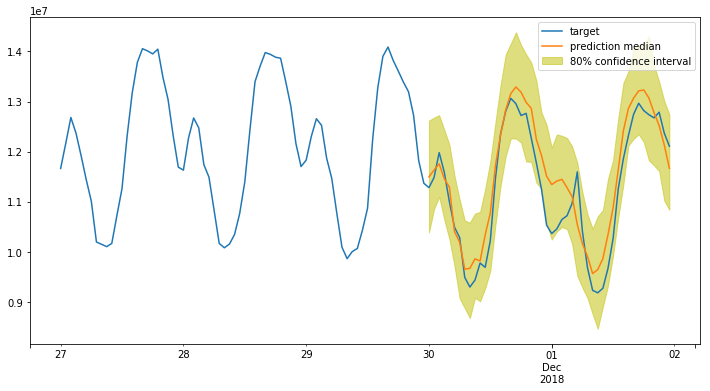

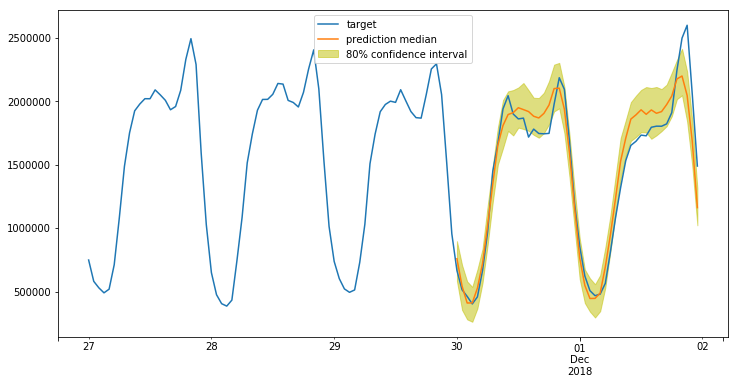

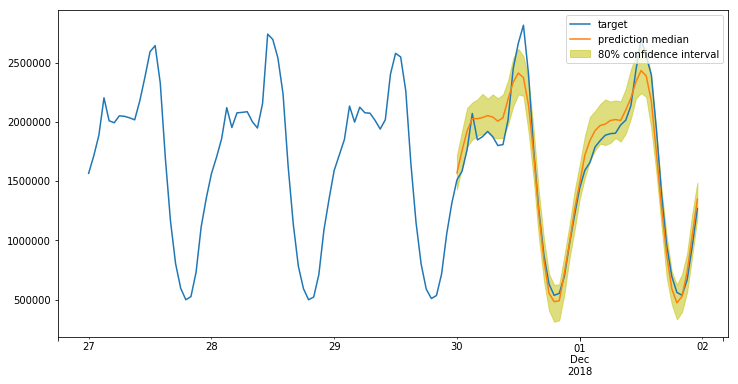

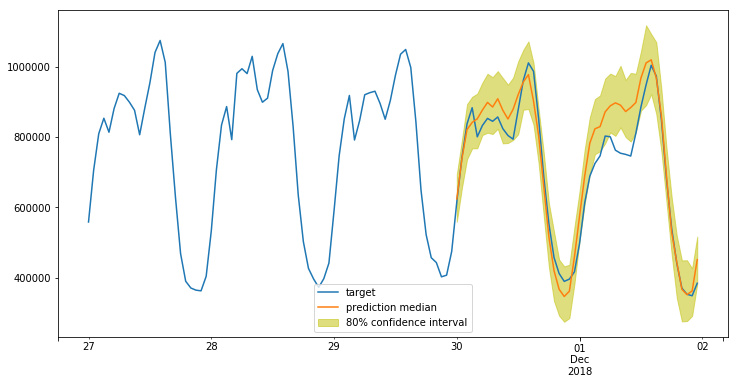

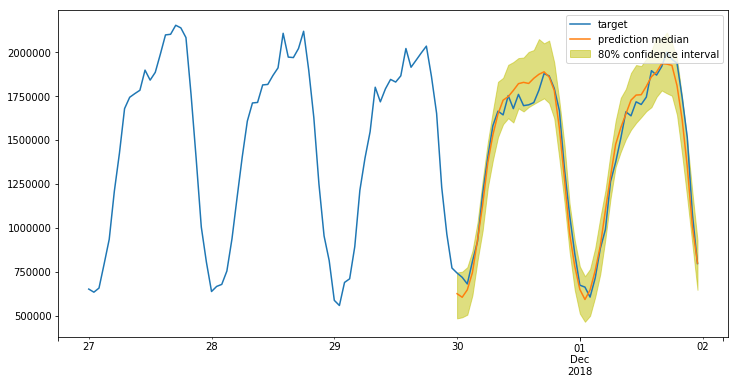

In [106]:
for k in range(len(list_of_wiki_pred)):
    plt.figure(figsize=(12,6))
    actual_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k]['0.1']
    p90 = list_of_wiki_pred[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Make prediction for `synthetic` data: sin() with noise.

Data contain 200 noisy time series, each consisting of 400 data points and with seasonality of 24 hours. 
All time series start at the same time point `t0`.

In [21]:
t0 = '2016-01-01 00:00:00'
data_length = 400
num_ts = 200
period = 24

In [41]:
time_series_synthetic = []
for k in range(num_ts):
    level = 100 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
    time_series_synthetic.append(pd.Series(data=data, index=index))

In [101]:
#time_series_synthetic[:1]

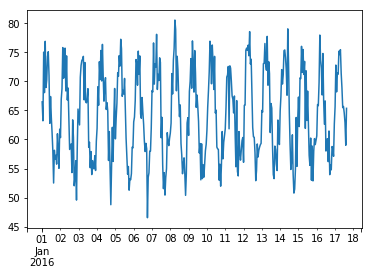

In [43]:
time_series_synthetic[0].plot()
plt.show()

In [42]:
time_series_to_predict = []
for ts in time_series_synthetic:
    time_series_to_predict.append(ts[:-prediction_length])

In [103]:
#time_series_to_predict[:1]

In [44]:
list_of_df = predictor.predict(time_series_to_predict[:5])
actual_data = time_series_synthetic[:5]

In [45]:
len(list_of_df[0]['0.5'].values)

48

In [46]:
len(actual_data[0][-prediction_length:].values)

48

#### moving average as a baseline model



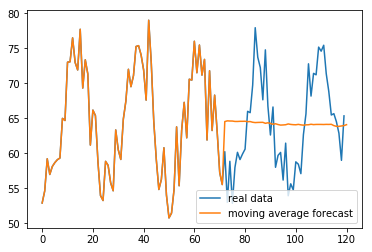

In [47]:
db = actual_data[0][-prediction_length-context_length:].values
forecast = np.zeros(len(db) + 1)
optimal_n = context_length
for i in range(0, optimal_n):
    forecast[i] = db[i]
for i in range(0, len(db) - optimal_n + 1):
        forecast[i+optimal_n] = np.mean(db[i:i+optimal_n])
plt.plot(db,label = 'real data')
plt.plot(forecast, label = 'moving average forecast')
plt.legend()
plt.show()


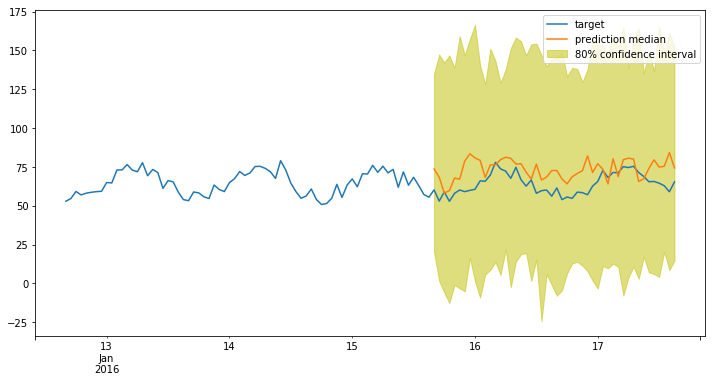

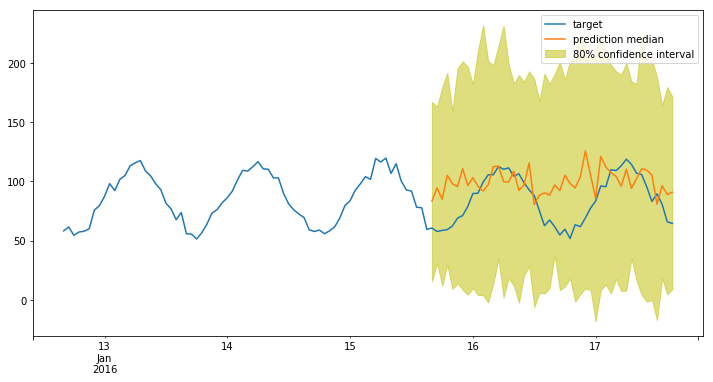

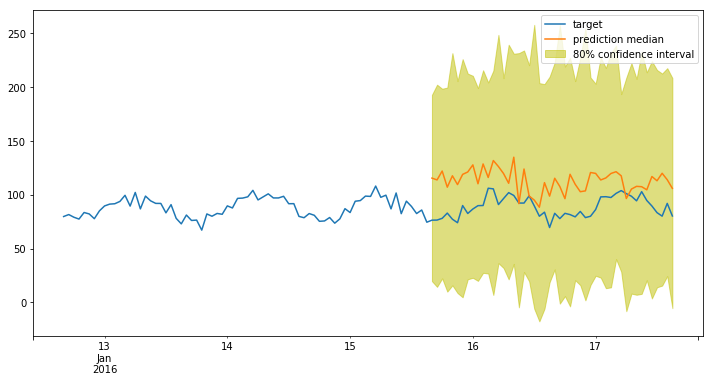

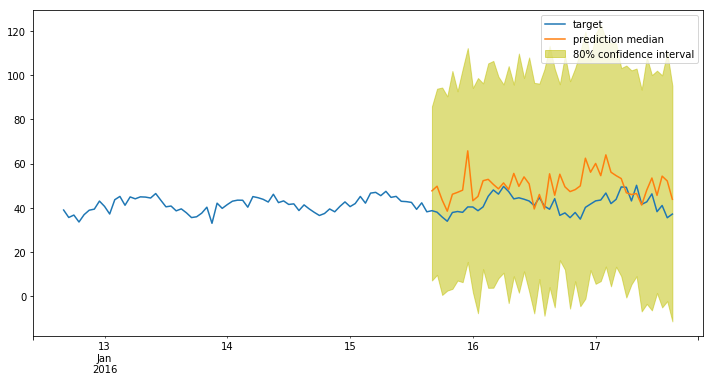

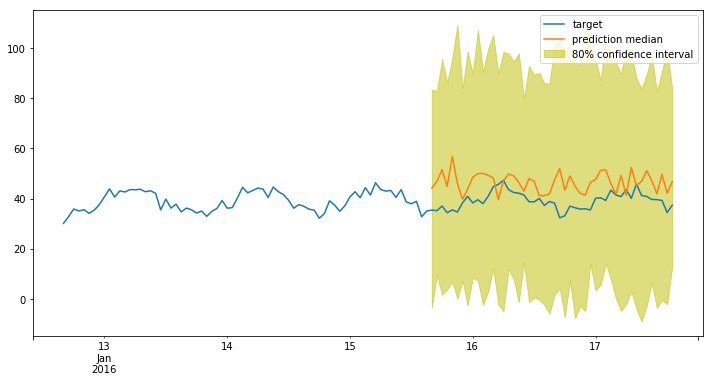

In [48]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    #plt.plot(forecast, label = 'moving average forecast')
    plt.legend()
    plt.show()

### Metrics to evaluate the prediction
- Mean absolute percentage error
- Mean absolute error with log1p
- Symmetric mean absolute percentage error
- others?

In [33]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE, rounded up to the closest integet
def rounded_smape(true, predicted):
    true_o = np.int(np.round(true))
    pred_o = np.round(predicted).astype(np.int32)
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# SMAPE as Kaggle calculates it
def kaggle_smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape


# MAE on log1p
def mae(true, predicted):
    true_o = np.log1p(true)
    pred_o = np.log1p(predicted)
    error = np.abs(true_o - pred_o)/2
    return error

In [34]:
def plot_smape(true_y, x_start, x_end):
    x = np.linspace(x_start,x_end, num=100)
    plt.plot(x, differentiable_smape(true_y, x), label='differentiable')
    plt.plot(x, rounded_smape(true_y, x), label='rounded')
    plt.plot(x, mae(true_y, x), label='mae')
    plt.plot(x, kaggle_smape(true_y, x), label='kaggle')
    plt.xlabel('predicted value')
    plt.ylabel('Loss')
    plt.title('True value=' + str(true_y))
    plt.legend()

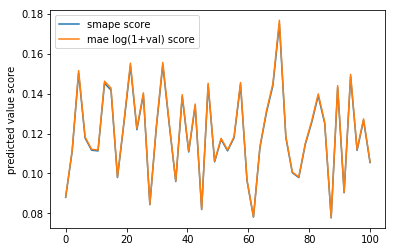

In [35]:
#plt.plot(x, differentiable_smape(true_y, x), label='differentiable')
metric_smape = differentiable_smape(list_of_df[k]['0.5'].values, list_of_df[0]['0.5'].values)
metric_maelog1p = mae(list_of_df[k]['0.5'].values, list_of_df[0]['0.5'].values)
x_points = np.linspace(0,100,48)
plt.figure()
plt.plot(x_points, metric_smape, label = 'smape score')
plt.plot(x_points, metric_maelog1p, label = 'mae log(1+val) score')
plt.ylabel('predicted value score')
plt.legend()

### Delete endpoint

In [107]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-01-22-02-03-45-802
